![MolHack](https://kaggle2.blob.core.windows.net/competitions/kaggle/8378/logos/header.png?t=2018-02-01-09-53-26)

***About us***

**Insilico Medicine**
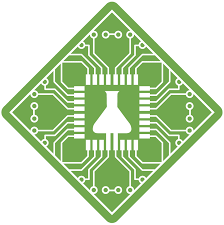

Insilico Medicine is a leading company in the field of Deep Learning for Drug Discovery. It was chosen by NVIDIA in top5 AI companies for social impact in 2017 and by CBInsights in top100 most promising private artificial intelligence companies in the world for 2018. 

 Besides business Insilico Medicine publish a lot:
1. The cornucopia of meaningful leads: Applying deep adversarial autoencoders for new molecule development in oncology. [link]
2. druGAN: An Advanced Generative Adversarial Autoencoder Model for de Novo Generation of New Molecules with Desired Molecular Properties in Silico.
3. Deep Learning Applications for Predicting Pharmacological Properties of Drugs and Drug Repurposing Using Transcriptomic Data.
4. Deep biomarkers of human aging: Application of deep neural networks to biomarker development.


***Introduction***

**RDKit**
![RDKitlogo](http://www.rdkit.org/Images/logo.png)

RDKit - is a collection of cheminformatics and machine-learning software written in C++ and Python. 

It can be easily installed by using Anaconda (the recommended way) or from source.


Helpful introduction to RDKit can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html). Unfortunately, RDKit is a weakly documented package, so you'll have to google a lot.

**SMILES**


[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (simplified molecular-input line-entry system) - is a string describing the structure of a chemical molecule. It doesn't contain any information about molecule 3D structure, but can be easily generated by Neural Networks

There is no strong need to fully understand their syntax because most chemical packages can read this form of representation. But, excellent explanations can be found by following this links - [video1](https://www.youtube.com/watch?v=kPSyI7DaBZA) and
[video2](https://www.youtube.com/watch?v=ZpVYoccNzEs)
![smilespng](https://www.researchgate.net/profile/Flemming_Jorgensen3/publication/8018882/figure/fig2/AS:299695877443585@1448464473177/Fig-2-Structural-information-for-a-molecule-can-be-given-as-a-1D-SMILES-string-a-2D.png)

**MACCS**

A few approaches exist to represent molecule structure and properties in a bit string format (called molecular fingerprint). You can read more about them in https://www.ncbi.nlm.nih.gov/pubmed/26558489. One of such methods is called MACCS. It is implemented in RDKit

**Conformers and pharmacophores**

 A pharmacophore is defined as a set of 3D points with special properties. For example, one point may specify that some hydrophobic part of a molecule must be in proximity to this point. 
 ![pharmacophore](https://www.dovepress.com/cr_data/article_fulltext/s46000/46843/img/fig2.jpg)
 
 We say that a molecule fits a pharmacophore if this molecule satisfies all constraints, induced by the pharmacophore. To test this, we have to test its different 3D <a href="https://en.wikipedia.org/wiki/Conformational_isomerism">conformations</a>, i.e. shapes. 
 
 There are a few approaches for generating a diverse set of conformations, given the optimal one, we have used chemical package [OpenBabel](http://openbabel.org/wiki/Main_Page) to produce conformers while computing our train dataset, but there a lot of our software for solving that task. For more details, you can read [this article](http://csmres.co.uk/cs.public.upd/article-downloads/2010-2011_2.pdf).


**OpenBabel**
![openbabel logo](http://openbabel.org/babel256.png)

Open Babel is a chemical toolbox designed to work with different molecules formats. It has bindings with python, but they have almost no documentation, so we recommend to use it from the command line. It was used to generate conformers during datasets calculation. More info about the way, you can create conformers for molecule by OpenBabel can be found [here](http://open-babel.readthedocs.io/en/latest/3DStructureGen/multipleconformers.html).

It can be installed by Anaconda or from source code

**Align-It**

For pharmacophore search during dataset preparation, this program has been used. You can find all info about program functionality and installation instructions from this [link](http://silicos-it.be.s3-website-eu-west-1.amazonaws.com/software/align-it/1.0.4/align-it.html#alignit-generating-pharmacophore-points)

Here we are loading some modules for future work

In [47]:
import sys
for entry in sys.path:
    if 'python2.7' in entry:
        sys.path.remove(entry)

In [2]:
sys.path.remove('/usr/local/lib/python2.7/site-packages/mxnet-0.9.1-py2.7-macosx-10.11-x86_64.egg')

In [3]:
import numpy as np
import lightgbm as lgb
import pandas as pd
import keras

Using Theano backend.


Here you can find some useful code for reading the output of Align-It program (PHAR format). The CSV format also exists in dataset files

In [119]:
class PharmacophoreException(Exception):
    pass

class PharmacophoreFileEndException(PharmacophoreException):
    pass

class PharmacophorePoint(object):
    def __init__(self, code, cx, cy, cz, alpha, norm, nx, ny, nz):
        self.code = code
        self.cx = float(cx)
        self.cy = float(cy)
        self.cz = float(cz)
        self.alpha = float(alpha)
        self.norm = int(norm)
        self.nx = float(nx)
        self.ny = float(ny)
        self.nz = float(nz)
    
    @classmethod
    def from_line(cls, line):
        return cls(*line.split())
    
    def to_line(self):
        return "{} {} {} {} {} {} {} {} {}".format(self.code, self.cx, self.cy, self.cz, self.alpha, self.norm,\
                                                self.nx, self.ny, self.nz)
    
    def __str__(self):
        return self.to_line()
        
    
    
class Pharmacophore(object):
    def __init__(self, name, points):
        self.name = name
        self.points = points
        
    @classmethod
    def from_stream(cls, stream):
        name = stream.readline().strip()
        points = []
        line = stream.readline().strip()
        if not line:
            raise PharmacophoreFileEndException("End of file")
            
        while line != "$$$$" or not line:
            points.append(PharmacophorePoint.from_line(line))
            line = stream.readline().strip()
            
        if not line:
            raise PharmacophoreException("Wrong format, no end line")
        return cls(name, points)
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as fd:
            return cls.from_stream(fd)
            
    def write_to_stream(self, stream):
        stream.write("{}\n".format(self.name))
        for point in self.points:
            stream.write("{}\n".format(point.to_line()))
        stream.write("$$$$\n".format(self.name))
            
    def write_to_file(self, file_path):
        with open(file_path, "w") as fd:
            self.write_to_stream(fd)
            
    def __str__(self):
        return  "{}\n{}\n$$$$".format(self.name,
                                      "\n".join(str(x) for x in self.points))
    
    def __len__(self):
        return len(self.points)
    
    def sample(self, name, n):
        points = sample(self.points, min(n, len(self)))
        return Pharmacophore(name, points)

class PharmDatabaseException(Exception):
    pass


def calc_pharmacophore(lig_path, ph_path):
    proc = Popen(
        "align-it --dbase {} --pharmacophore {}".format(lig_path, ph_path),
        shell=True,
        stdout=PIPE, stderr=PIPE)
    _ = proc.communicate()
    

class PharmDatabase(object):
    def __init__(self, path_to_ligands, path_to_ph_db, is_calculated=False):
        self.path_to_ligands = path_to_ligands
        self.path_to_ph_db = path_to_ph_db
        self.is_calculated = is_calculated
    
    def repair_database(self):
        pass
    
    def calc_database(self):
        if not self.path_to_ph_db:
            self.calc_pharmacophore(self.path_to_ligands, self.path_to_ph_db)

    
    def sample_database(self):
        pass
    
    def iter_database(self):
        if not self.is_calculated:
            raise PharmDatabaseException("Not calculated")
        with open(self.path_to_ph_db, 'r') as fd:
            while True:
                try:
                    pharmacophore = Pharmacophore.from_stream(fd)
                    yield pharmacophore
                except PharmacophoreFileEndException:
                    break
    

Basic code for converting molecule from smiles to MACCS. By default, size of MACCS bit string is 167

In [ ]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
def smi_to_maccs(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    else:
        return np.zeros(MACCS_SIZE)
    
MACCS_SIZE = 167

In [5]:
PATH_TO_TRAIN_SMILES = "train_smiles.csv"
PATH_TO_TEST_SMILES = "test1_smiles.csv"

In [6]:
test_smiles = pd.read_csv(PATH_TO_TEST_SMILES)['smiles']
#train_smiles = pd.read_csv(PATH_TO_TRAIN_SMILES)['smiles']

#PHARM_TRAIN_SMILES = np.zeros((train_smiles.shape[0], MACCS_SIZE), dtype=np.int8)
PHARM_TEST_SMILES = np.zeros((test_smiles.shape[0], 167), dtype=np.int8)

In [6]:
for ind, smi in enumerate(train_smiles):
    PHARM_TRAIN_SMILES[ind] = smi_to_maccs(smi)
for ind, smi in enumerate(test_smiles):
    PHARM_TEST_SMILES[ind] = smi_to_maccs(smi)

In [7]:
np.save("PHARM_TRAIN_SMILES.npy", PHARM_TRAIN_SMILES)
np.save("PHARM_TEST_SMILES.npy", PHARM_TEST_SMILES)

In [7]:
PHARM_TRAIN_SMILES = np.load("PHARM_TRAIN_SMILES.npy")
PHARM_TEST_SMILES = np.load("PHARM_TEST_SMILES.npy")

Now we are downloading train and test pharmacophores files for our dataset. While here we use PHAR format, using by Align-It, CSV format for train and test datasets is also provided

In [8]:
PH_TRAIN_PATH = "train_pharmacophores.phar"
PH_TEST_PATH = "test1_pharmacophores.phar"
train_sample_pharmacophor_db = PharmDatabase(path_to_ligands=None, 
                                       path_to_ph_db=PH_TRAIN_PATH, 
                                       is_calculated=True)
test_sample_pharmacophor_db = PharmDatabase(path_to_ligands=None, 
                                       path_to_ph_db=PH_TEST_PATH, 
                                       is_calculated=True)

In [9]:
#train_pharmacophores = [p for p in train_sample_pharmacophor_db.iter_database()]
test_pharmacophores = [p for p in test_sample_pharmacophor_db.iter_database()]

So, now we have to encode our pharmacophores somehow. The easiest way (not the smartest one) is to count the occurrence of each type of point in the pharmacophore and store this information as a vector

In [10]:
MAPPING = {"AROM" : 0,
"HDON" : 1,
"HACC" : 2,
"LIPO" : 3,
"POSC" : 4,
"NEGC" : 5,
"HYBH" : 6,
"HYBL" : 7,
"EXCL": 8}

def phar_to_bins(phar):
    v = np.zeros(len(MAPPING))
    for p in phar.points:
        v[MAPPING[p.code]] += 1
    return v

In [11]:
PHARM_TRAIN_X = np.zeros( (len(train_pharmacophores), len(MAPPING)), dtype=np.int8)
for ind, i in enumerate(train_pharmacophores):
    PHARM_TRAIN_X[ind] = phar_to_bins(i)
                
PHARM_TEST_X = np.zeros( (len(test_pharmacophores), len(MAPPING)), dtype=np.int8)
for ind, i in enumerate(test_pharmacophores):
    PHARM_TEST_X[ind] = phar_to_bins(i)

NameError: name 'train_pharmacophores' is not defined

In [13]:
np.save("PHARM_TRAIN_X.npy", PHARM_TRAIN_X)
np.save("PHARM_TEST_X.npy", PHARM_TEST_X)

In [11]:
PHARM_TRAIN_X = np.load("PHARM_TRAIN_X.npy")
PHARM_TEST_X = np.load("PHARM_TEST_X.npy")

In [12]:
PHARM_TRAIN_X.shape[0]

13246

Here we join info about pharmacopores and ligands in simple matrix. To avoid memory error,  only a part of train data is used

In [13]:
np.random.seed(731)
train_pharmacophore_indices = np.random.choice(PHARM_TRAIN_X.shape[0], size=1500, replace=False)
train_ligands_indices = np.random.choice(PHARM_TRAIN_SMILES.shape[0], size=1500, replace=False)
np.random.seed(731)

In [14]:
Y_train_full = np.zeros(PHARM_TRAIN_X.shape[0] * PHARM_TRAIN_SMILES.shape[0], dtype=np.int8)
ind = 0
with open("train_info.csv") as in_file:
    in_file.readline()
    for line in in_file:
        Y_train_full[ind] = int(line.strip().split(",")[1])
        ind += 1

FileNotFoundError: [Errno 2] No such file or directory: 'train_info.csv'

In [17]:
np.save("Y_train.npy", Y_train_full)

In [120]:
Y_train_full = np.load("Y_train.npy")

In [121]:
X_train = np.zeros( (train_pharmacophore_indices.shape[0] * train_ligands_indices.shape[0],
            PHARM_TRAIN_X[0].shape[0] + 167),  dtype=np.int8)
Y_train = np.zeros(train_pharmacophore_indices.shape[0] * train_ligands_indices.shape[0],  dtype=np.int8)

In [122]:
import sys
sys.getsizeof(X_train)

396000112

In [124]:
for li, lig_id in enumerate(train_ligands_indices):
    for pi, p_ind in enumerate(train_pharmacophore_indices):
        x_ind = lig_id * PHARM_TRAIN_X.shape[0] + p_ind
        xi = li * train_pharmacophore_indices.shape[0] + pi
        X_train[xi, :len(MAPPING)] = PHARM_TRAIN_X[p_ind]
        X_train[xi, len(MAPPING):] = PHARM_TRAIN_SMILES[lig_id]
        Y_train[xi] = Y_train_full[x_ind] 

In [144]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.utils import np_utils

seed = 15
np.random.seed(seed)

encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)
dummy_y = np_utils.to_categorical(encoded_Y)

Train classifier and predict values for batches of test dataset to avoid storing all X_test matrix in memory

In [145]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

In [146]:
def baseline_model():
    
    model = Sequential()
    model.add(Dense(20, input_dim=176, activation='relu', use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros'
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu', use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros',
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu', use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros' 
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])
    return model

In [147]:
classifier = KerasClassifier(build_fn = baseline_model, epochs=15, batch_size=10000, verbose=1)

In [148]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [149]:
results = cross_val_score(classifier, X_train, dummy_y, cv=kfold)

Epoch 1/15
2025000/2025000 [==============================] - 12s 6us/step - loss: 0.1592 - mean_absolute_error: 0.1592
Epoch 2/15
2025000/2025000 [==============================] - 12s 6us/step - loss: 0.1541 - mean_absolute_error: 0.1541
Epoch 3/15
2025000/2025000 [==============================] - 16s 8us/step - loss: 0.1491 - mean_absolute_error: 0.1491
Epoch 4/15
2025000/2025000 [==============================] - 13s 6us/step - loss: 0.1466 - mean_absolute_error: 0.1466
Epoch 5/15
2025000/2025000 [==============================] - 13s 6us/step - loss: 0.1449 - mean_absolute_error: 0.1449
Epoch 6/15
2025000/2025000 [==============================] - 17s 8us/step - loss: 0.1436 - mean_absolute_error: 0.1436
Epoch 7/15
2025000/2025000 [==============================] - 16s 8us/step - loss: 0.1429 - mean_absolute_error: 0.1429
Epoch 8/15
2025000/2025000 [==============================] - 19s 9us/step - loss: 0.1424 - mean_absolute_error: 0.1424
Epoch 9/15
2025000/2025000 [============

ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

In [150]:
classifier.fit(X_train, dummy_y, verbose=0)

In [111]:
batch_size = 10000
Y_test = np.zeros(len(test_smiles) * len(test_pharmacophores), dtype=np.int32)
X_batch = np.zeros((batch_size, PHARM_TRAIN_X[0].shape[0] + 167), dtype=np.int32)

ind = 0
glob_ind = 0
for lig_id in range(len(test_smiles)):
    for p_id in range(len(test_pharmacophores)):
        X_batch[ind, :len(MAPPING)] = PHARM_TEST_X[p_id]
        X_batch[ind, len(MAPPING):] = PHARM_TEST_SMILES[p_id]
        ind += 1
        glob_ind += 1
        if ind == batch_size:
            ind = 0
            Y_test[glob_ind-batch_size:glob_ind] = classifier.predict(X_batch, verbose=0)
    

KeyboardInterrupt: 

Now let's make a submission

In [167]:
with open("submission.csv", "w") as out_file:
    out_file.write("ligid_pharmid,score\n")
    for ligind in range(len(test_smiles)):
        for pind in range(len(test_pharmacophores)):
            global_ind = ligind * len(test_pharmacophores)  + pind
            out_file.write("{},{}\n".format(global_ind, int(Y_test[global_ind])))